In [1]:
from init import * 
from utils import (
    device,
    cuda,
    calculate_mean_std_mnist,
    show__random_img,
    config
)
from model import Net
from transforms import (
    train_transforms,
    test_transforms,
    custom_augmentation,
    MNISTDataset
)

c:\Users\muthu\miniconda3\envs\venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
torch.cuda.amp.autocast(enabled=False)

# REPRODUCE
torch.backends.cudnn.deterministi=True
random.seed(hash('setting random seeds')% 2**32-1)
np.random.seed(hash('improves reproducibility')%2**32-1)
torch.manual_seed(hash("by removing stochasticity")%2**32-1)
torch.cuda.manual_seed_all(hash('so runs are repetable')%2**32-1)

In [3]:
mnist_data = datasets.MNIST( root=config['data']['dir_path'], download=False, transform=transforms.ToTensor() ,)
mean,std= calculate_mean_std_mnist(mnist_data)
print(mean,std)

0.13066023588180542 0.3015025854110718


In [4]:
train_data = datasets.MNIST(config['data']['dir_path'], train=True,  download=False, transform=train_transforms)
test_data  = datasets.MNIST(config['data']['dir_path'], train=False, download=False, transform=test_transforms)

In [5]:
if cuda:
    kwargs = {
        'batch_size':config['batch_size'],
        'shuffle': config['shuffle'],
        'num_workers':config['num_workers'],
        'pin_memory':config['pin_memory']
    }
else:
    kwargs = {'batch_size':32,'shuffle':True}

train_loader = DataLoader(train_data,**kwargs)
test_loader  = DataLoader(test_data, **kwargs)

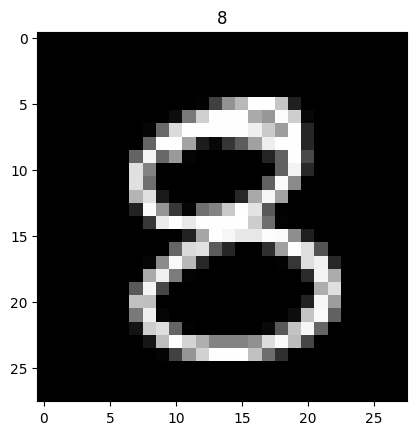

In [6]:
show__random_img()

In [7]:
# Data to plot accuracy and loss graphs (INIT)
train_losses = []
test_losses = []
train_acc = []
test_acc = []

test_incorrect_pred = {'images': [], 'ground_truths': [], 'predicted_vals': []}

def GetCorrectPredCount(pPrediction, pLabels):
  return pPrediction.argmax(dim=1).eq(pLabels).sum().item()


def train(model, device, train_loader, optimizer, criterion):
  model.train()
  pbar = tqdm(train_loader)

  train_loss = 0
  correct = 0
  processed = 0

  for batch_idx, (data, target) in enumerate(pbar):
    data, target = data.to(device), target.to(device)
    optimizer.zero_grad()

    # Predict
    pred = model(data)

    # Calculate loss
    loss = criterion(pred, target)
    train_loss+=loss.item()

    # Backpropagation
    loss.backward()
    optimizer.step()

    correct += GetCorrectPredCount(pred, target)
    processed += len(data)

    pbar.set_description(desc= f'Train: Loss={loss.item():0.4f} Batch_id={batch_idx} Accuracy={100*correct/processed:0.2f}')

  train_acc.append(100*correct/processed)
  train_losses.append(train_loss/len(train_loader))
  return train_loss

def test(model, device, test_loader, criterion):
    model.eval()

    test_loss = 0
    correct = 0

    with torch.no_grad():
        for batch_idx, (data, target) in enumerate(test_loader):
            data, target = data.to(device), target.to(device)

            output = model(data)
            test_loss += criterion(output, target, reduction='sum').item()  # sum up batch loss

            correct += GetCorrectPredCount(output, target)


    test_loss /= len(test_loader.dataset)
    test_acc.append(100. * correct / len(test_loader.dataset))
    test_losses.append(test_loss)
    
    print('Test set: Average loss: {:.4f}, Accuracy: {}/{} ({:.4f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))
    return test_loss

In [8]:
model = Net().to(device)

In [9]:
for name,weights in model.named_parameters():
    print(f"{name}\t\t {weights.shape}")

conv1.0.weight		 torch.Size([8, 1, 3, 3])
conv1.2.weight		 torch.Size([8])
conv1.2.bias		 torch.Size([8])
conv1.4.weight		 torch.Size([10, 8, 3, 3])
conv1.6.weight		 torch.Size([10])
conv1.6.bias		 torch.Size([10])
conv1.8.weight		 torch.Size([10, 10, 3, 3])
conv1.10.weight		 torch.Size([10])
conv1.10.bias		 torch.Size([10])
trans1.1.weight		 torch.Size([8, 10, 1, 1])
conv2.0.weight		 torch.Size([10, 8, 3, 3])
conv2.1.weight		 torch.Size([10])
conv2.1.bias		 torch.Size([10])
conv2.4.weight		 torch.Size([12, 10, 3, 3])
conv2.5.weight		 torch.Size([12])
conv2.5.bias		 torch.Size([12])
conv2.8.weight		 torch.Size([12, 12, 3, 3])
conv2.9.weight		 torch.Size([12])
conv2.9.bias		 torch.Size([12])
trans2.1.weight		 torch.Size([8, 12, 1, 1])
trans2.2.weight		 torch.Size([8])
trans2.2.bias		 torch.Size([8])
conv3.0.weight		 torch.Size([10, 8, 3, 3])
conv3.1.weight		 torch.Size([10])
conv3.1.bias		 torch.Size([10])
conv3.4.weight		 torch.Size([12, 10, 3, 3])
conv3.6.weight		 torch.Size([12])
con

In [10]:
summary(model=model,input_size=(1,28,28),device='cuda');

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [-1, 8, 28, 28]              72
              ReLU-2            [-1, 8, 28, 28]               0
       BatchNorm2d-3            [-1, 8, 28, 28]              16
         Dropout2d-4            [-1, 8, 28, 28]               0
            Conv2d-5           [-1, 10, 28, 28]             720
              ReLU-6           [-1, 10, 28, 28]               0
       BatchNorm2d-7           [-1, 10, 28, 28]              20
         Dropout2d-8           [-1, 10, 28, 28]               0
            Conv2d-9           [-1, 10, 28, 28]             900
             ReLU-10           [-1, 10, 28, 28]               0
      BatchNorm2d-11           [-1, 10, 28, 28]              20
        Dropout2d-12           [-1, 10, 28, 28]               0
        MaxPool2d-13           [-1, 10, 15, 15]               0
           Conv2d-14            [-1, 8,

In [11]:

optimizer = optim.SGD(model.parameters(), lr=config['optimizer']['lr'], momentum=config['optimizer']['momentum'])
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer,factor=0.1,patience=2,verbose=True) # step_size=config['scheduler']['step_size'], gamma=config['scheduler']['gamma'], 

criterion =  F.nll_loss
num_epochs = config['training']['num_epochs']

for epoch in range(1, num_epochs+1):
  print(f'Epoch {epoch}')
  train_loss = train(model, device, train_loader, optimizer, criterion)
  test_loss  = test(model, device, test_loader, criterion)
  scheduler.step(train_loss)

c:\Users\muthu\miniconda3\envs\venv\Lib\site-packages\torch\optim\lr_scheduler.py:28: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn("The verbose parameter is deprecated. Please use get_last_lr() "


Epoch 1


Train: Loss=0.0558 Batch_id=468 Accuracy=87.41: 100%|██████████| 469/469 [00:08<00:00, 56.75it/s] 


Test set: Average loss: 0.0719, Accuracy: 9787/10000 (97.8700%)

Epoch 2


Train: Loss=0.1245 Batch_id=468 Accuracy=95.37: 100%|██████████| 469/469 [00:08<00:00, 58.21it/s] 


Test set: Average loss: 0.0469, Accuracy: 9844/10000 (98.4400%)

Epoch 3


Train: Loss=0.0808 Batch_id=468 Accuracy=96.45: 100%|██████████| 469/469 [00:08<00:00, 58.10it/s] 


Test set: Average loss: 0.0362, Accuracy: 9882/10000 (98.8200%)

Epoch 4


Train: Loss=0.0406 Batch_id=468 Accuracy=96.90: 100%|██████████| 469/469 [00:08<00:00, 57.80it/s] 


Test set: Average loss: 0.0302, Accuracy: 9902/10000 (99.0200%)

Epoch 5


Train: Loss=0.0870 Batch_id=468 Accuracy=97.33: 100%|██████████| 469/469 [00:08<00:00, 57.29it/s] 


Test set: Average loss: 0.0363, Accuracy: 9885/10000 (98.8500%)

Epoch 6


Train: Loss=0.0843 Batch_id=468 Accuracy=97.46: 100%|██████████| 469/469 [00:08<00:00, 57.84it/s] 


Test set: Average loss: 0.0295, Accuracy: 9896/10000 (98.9600%)

Epoch 7


Train: Loss=0.0491 Batch_id=468 Accuracy=97.65: 100%|██████████| 469/469 [00:08<00:00, 57.85it/s] 


Test set: Average loss: 0.0282, Accuracy: 9904/10000 (99.0400%)

Epoch 8


Train: Loss=0.0296 Batch_id=468 Accuracy=97.71: 100%|██████████| 469/469 [00:08<00:00, 58.19it/s] 


Test set: Average loss: 0.0285, Accuracy: 9912/10000 (99.1200%)

Epoch 9


Train: Loss=0.0789 Batch_id=468 Accuracy=97.82: 100%|██████████| 469/469 [00:08<00:00, 57.81it/s] 


Test set: Average loss: 0.0273, Accuracy: 9908/10000 (99.0800%)

Epoch 10


Train: Loss=0.0613 Batch_id=468 Accuracy=97.92: 100%|██████████| 469/469 [00:08<00:00, 58.19it/s] 


Test set: Average loss: 0.0264, Accuracy: 9915/10000 (99.1500%)

Epoch 11


Train: Loss=0.0734 Batch_id=468 Accuracy=97.95: 100%|██████████| 469/469 [00:08<00:00, 57.22it/s] 


Test set: Average loss: 0.0262, Accuracy: 9911/10000 (99.1100%)

Epoch 12


Train: Loss=0.0768 Batch_id=468 Accuracy=98.03: 100%|██████████| 469/469 [00:08<00:00, 57.08it/s] 


Test set: Average loss: 0.0246, Accuracy: 9924/10000 (99.2400%)

Epoch 13


Train: Loss=0.0278 Batch_id=468 Accuracy=98.10: 100%|██████████| 469/469 [00:08<00:00, 57.28it/s] 


Test set: Average loss: 0.0243, Accuracy: 9916/10000 (99.1600%)

Epoch 14


Train: Loss=0.0178 Batch_id=468 Accuracy=98.17: 100%|██████████| 469/469 [00:08<00:00, 58.03it/s] 


Test set: Average loss: 0.0226, Accuracy: 9933/10000 (99.3300%)

Epoch 15


Train: Loss=0.1330 Batch_id=468 Accuracy=98.26: 100%|██████████| 469/469 [00:08<00:00, 57.69it/s] 


Test set: Average loss: 0.0206, Accuracy: 9937/10000 (99.3700%)



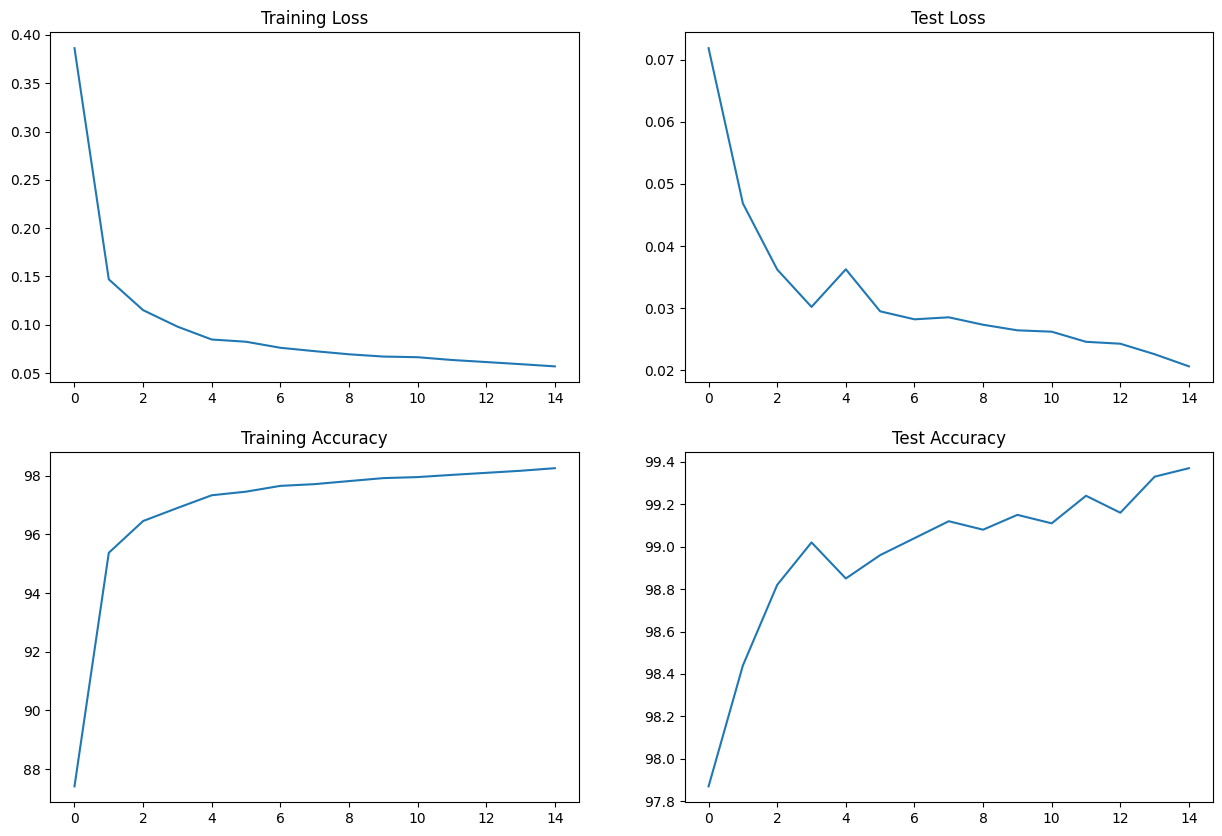

In [12]:
fig, axs = plt.subplots(2,2,figsize=(15,10))

axs[0, 0].plot(train_losses)
axs[0, 0].set_title("Training Loss")

axs[1, 0].plot(train_acc)
axs[1, 0].set_title("Training Accuracy")

axs[0, 1].plot(test_losses)
axs[0, 1].set_title("Test Loss")

axs[1, 1].plot(test_acc)
axs[1, 1].set_title("Test Accuracy")
plt.show()

torch.Size([128, 1, 28, 28]) torch.Size([128])


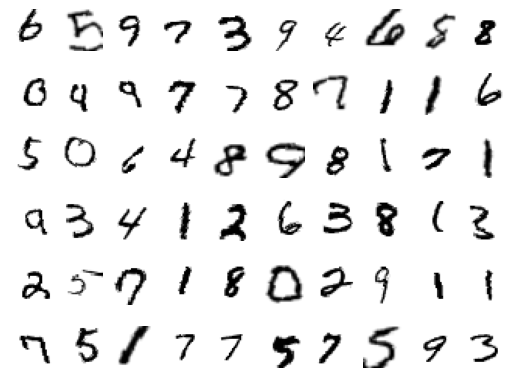

In [13]:
fig = plt.figure()

num_of_imgs=60

dataiter = iter(train_loader)
imgs,labels = next(dataiter)

print(imgs.shape,labels.shape)

for idx in range(1,num_of_imgs+1):
    plt.subplot(6,10,idx)
    plt.axis('off')
    plt.imshow(imgs[idx].numpy().squeeze(),cmap='binary')
plt.show()
